In [2]:
library(astsa)
library(forecast)
library(FitAR)
library(Metrics)

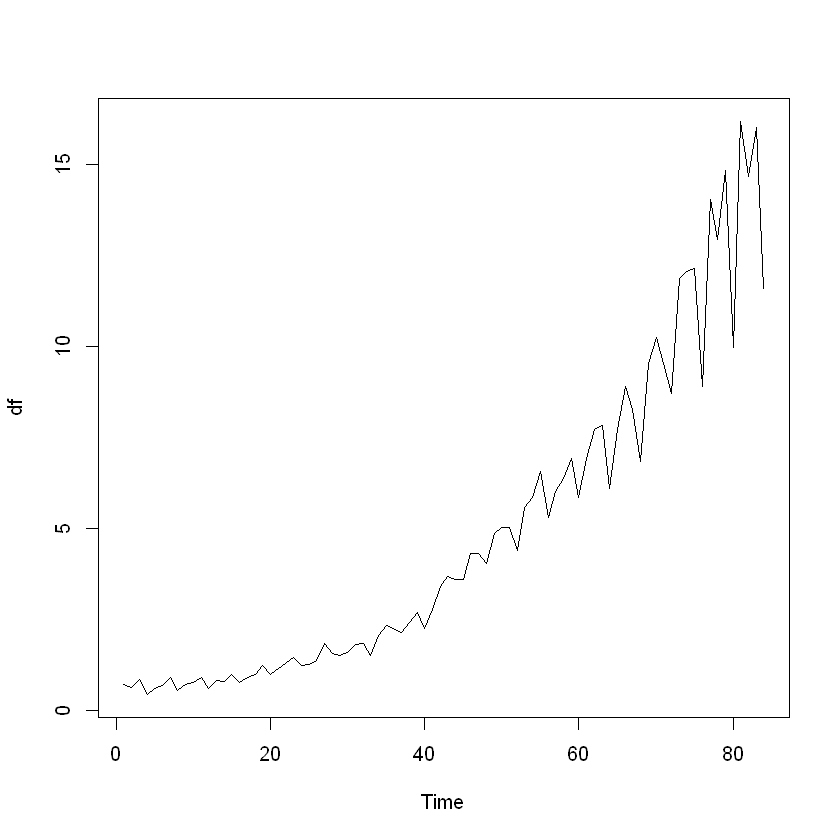

In [9]:
df <- JohnsonJohnson
df <- c(df)
plot.ts(df)